In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
import time
import os
from datetime import datetime

In [5]:
# the body is modelled by an N by N lattice
size = 10
lat = np.zeros([size,size])

T_num_in = 3
B_num_in = 10

BB_int = 1
TT_int = 2
BT_int = 4
eps = ([0,      0,      0], 
       [0, BB_int, BT_int],
       [0, BT_int, TT_int])
# interaction matrix
def interaction_matrix(BB_int,TT_int, BT_int, type1, type2):
       eps_matrix = ([0,      0,      0], 
              [0, BB_int, BT_int],
              [0, BT_int, TT_int])
       if type1 == type2 == 1:
              eps = TT_int
       if type1 == type2 == 2:
              eps = BT_int
       if type1*type2 ==2:
              eps = BT_int
       else:
              eps =0
       return eps



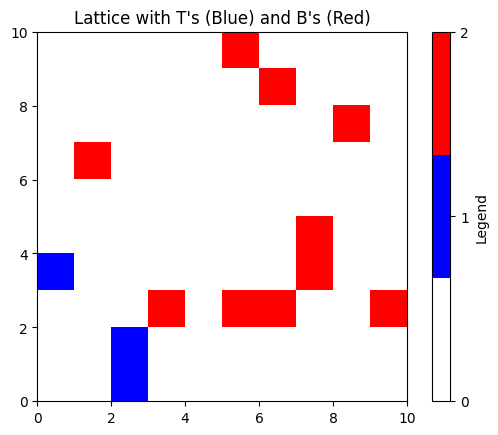

In [6]:
# Place T cells and bacteria
def create_lattice(lattice_length, lattice, T_num, B_num):
    # Place T's randomly
    t_coords = set()
    while len(t_coords) < T_num:
        t = (np.random.randint(lattice_length), np.random.randint(lattice_length))
        if t not in t_coords:
            t_coords.add(t)
            lattice[t[0], t[1]] = 1
    # Place B's randomly
    b_coords = set()
    while len(b_coords) < B_num:
        b = (np.random.randint(lattice_length), np.random.randint(lattice_length))
        if b not in b_coords and b not in t_coords:
            b_coords.add(b)
            lattice[b[0], b[1]] = 2
    
    empty_coords = np.where(lattice == 0)   
    empty_coords = np.array(empty_coords)           # coordinates of 0's
    
    density = (T_num + B_num)/size**2
            
    return lattice, empty_coords, t_coords, b_coords, density


# Create a colormap for red (B) and blue (T)
cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

# Plot the lattice
plt.imshow(create_lattice(size, lat, T_num_in, B_num_in)[0], cmap=cmap, extent=[0, size, 0, size])
plt.colorbar(ticks=[0, 1, 2], label="Legend")
plt.title("Lattice with T's (Blue) and B's (Red)")

#plt.grid(True, linewidth=0.5, color='black')

plt.show()

In [7]:
# showing lattices as they evolve 

def lattice_plots(lattice_history, selected_indices):

    cmap = plt.get_cmap("binary", 2)

    for i in range(len(selected_indices)):

        # Create a plot
        plt.matshow(lattice_history[i], cmap=cmap)
       # plt.xticks(range(lattice.shape[1]))
        #plt.yticks(range(lattice.shape[0]))

        plt.grid(visible=False)

        plt.title(f"Lattice at Iteration {selected_indices[i]}")  # Add a title with the iteration number

        fig_name = f"Plot\Lattice_iter{selected_indices[i]}"
       # plt.savefig(fig_name)
        plt.show()

In [8]:
# randomly choose lattice site from array storing coordinates of 1's or 0's

def position_random(pos):
    col = np.random.choice(pos[0,:],1)
    #j = np.random.choice(pos[1,:],1)
    p = pos[:,col]
    return p,col 

In [9]:
###CHANGE ENERGY!!!
def energy(lattice,p,eps):
    s = lattice.shape[0]-1
    i = p[0]
    j = p[1]
    
    if i==0:
        up = lattice[s,j]   
    else:    
        up = lattice[i-1,j]

    if i == s:
        down = lattice[0,j]      
    else:
        down = lattice[i+1,j]

    if j == 0:
        left = lattice[i,s]        
    else:
        left = lattice[i,j-1]     

    if j == s:
        right = lattice[i,0]       
    else:
        right = lattice[i,j+1]
        
    directions = np.array(up,down,left,right)
    
    for k in directions: ##sums energy if next to bacteria!! Make this in relation to the matrix!!
        E =+ -interaction_matrix(BB_int,TT_int, BT_int,lattice[i,j],k) * 1 *(k) # 1 added because their /is/ or /hypothetically is/ a particle
    return E

In [10]:
# evaluate whether or not to move partice 

def evaluate_particle_move(lattice, pos0, pos1, pos2, T, E_total, eps):
    ###IF IT SHOULD NOT MOVE WE MOVE IT BACK AND ADD THE ENERGY LOST
    
    ##ALSO DECIDE IF WE  MOVE T AND EACH SETUP DOUBLE B
    #
    #
    p0, col0 = position_random(pos0) ###pick a hole to double bacteria and to move T
    p1, col1 = position_random(pos1) ###pick a T cell to move
    Ein = energy(lattice,p1,eps)
    Efin = energy(lattice,p0,eps)
    
    Ediff = Efin - Ein

    if Ediff < 0 :
        move = True
        
    else:
        probability = np.exp(-Ediff/T)
        #HAVE TO ADD THAT IT WANTS TO MOVE NEAR B!!!
       # probability = 0
        if random.random() < probability: # random.random gives between 0 and 1. Hence higher prob -> more move
            move = True 
        else:
            move = False
            
    ### ADDING THE BACTERIA!
    pb, colb = position_random(pos0)  
    lattice[pb[0], pb[1]] = 2
    pos2[:,colb] = [pb[0], pb[1]]
    ###Change the energy here because we add bacteria
    Ebact = energy(lattice,pb,eps)
    E_total  = E_total + Ebact
    
    if move: 
        #lattice = lattice_hypothetical
        lattice[p0[0], p0[1]] = 1
        # update arrays containing coordinates of 0's and 1's
        pos1[:,col1] = [p0[0], p0[1]]
        pos0[:,col0] = [p1[0], p1[1]]
        E_total = E_total + Ediff
        E_total = float(E_total)
    if move == False: ###Change the energy here because we add bacteria
        lattice[p0[0], p0[1]] = 0
        
    return lattice, pos1, pos0, move, E_total

In [11]:
###MAKE MONTECARLO!!!
def monte_carlo(T, eps, lattice_length, T_num, B_num, num_runs, num_lattices_to_store=None):
    lattice, pos0, pos1, pos2, density = create_lattice(lattice_length, lattice, T_num, B_num)
    #lattice_length
    
    for j in range(len(T)):

        for i in range(0,num_runs): # change to from one and append initial E and lattice to outisde

            #I DO NOT KNOW HOW TO MAKE T_s MOVE CLOSER TO B_s
            lattice, pos0, pos1, pos2, move, E_lattice = evaluate_particle_move(lattice, pos0, pos1, pos2, T[j], E_lattice, eps)
            
            #pos2 = pos2**2
            
    return lattice, T_num, B_num

In [16]:
# the interaction matrix can be used to decide how many bacteria are able to multiply. 
# if surrounded by T cells -> no division

num_runs = 10_000
T = np.arange(3,0.01,-0.1)
eps = 1        

T_num = 3
B_num = 10

density_max = 0.9         
size_mini = 50  
number_of_particles = density_max * size_mini**2

density = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
size_list = []

for i in range(num_runs):
    lattice,  T_num, B_num = monte_carlo(T, eps, size_mini, T_num, B_num, num_runs, num_lattices_to_store=None)


UnboundLocalError: cannot access local variable 'lattice' where it is not associated with a value